# Week 7 Discussion Questions: classify using CNN whether an image is of a damaged or an undamaged property from aerial photographs following a cyclone

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Download the dataset if it hasn't already been downloaded.
from pathlib import Path
if not Path("cyclone.zip").exists():
    print("Downloading dataset...")
    !wget https://pat-laub.github.io/DeepLearningMaterials/Lecture-6-Computer-Vision/cyclone.zip
else:
    print("Already downloaded.")

--2022-08-01 04:26:38--  https://pat-laub.github.io/DeepLearningMaterials/Lecture-6-Computer-Vision/cyclone.zip
Resolving pat-laub.github.io (pat-laub.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pat-laub.github.io (pat-laub.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84121970 (80M) [application/zip]
Saving to: ‘cyclone.zip’

cyclone.zip         100%[===================>]  80.22M   352MB/s    in 0.2s    

2022-08-01 04:26:44 (352 MB/s) - ‘cyclone.zip’ saved [84121970/84121970]



In [ ]:
!rm -rf cyclone
!unzip -o cyclone.zip > /dev/null
!rm -rf cyclone/test cyclone/validation
!mv cyclone/train/* cyclone
!rm -rf cyclone/train

In [ ]:
!pip install split-folders > /dev/null
!apt install tree > /dev/null

In [ ]:
import splitfolders
splitfolders.ratio("cyclone", output="cyclone-split",
    seed=1337, ratio=(0.6, 0.2, 0.2))


Copying files: 21492 files [00:02, 7512.45 files/s]


In [ ]:
!tree cyclone-split -L 1

cyclone-split
├── test
├── train
└── val

3 directories, 0 files


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

dataDir = "cyclone-split"
batchSize = 32
imgHeight = 128
imgWidth = 128
imgSize = (imgHeight, imgWidth)


In [ ]:
trainDS = image_dataset_from_directory(
    dataDir + "/train",
    image_size=imgSize,
    batch_size=batchSize)

valDS = image_dataset_from_directory(
    dataDir + "/val",
    image_size=imgSize,
    batch_size=batchSize)

testDS = image_dataset_from_directory(
    dataDir + "/test",
    image_size=imgSize,
    batch_size=batchSize)

Found 12894 files belonging to 2 classes.
Found 4297 files belonging to 2 classes.
Found 4301 files belonging to 2 classes.


In [ ]:
print(trainDS.class_names)

['damage', 'no_damage']


In [ ]:
X_batch, y_batch = next(iter(trainDS))

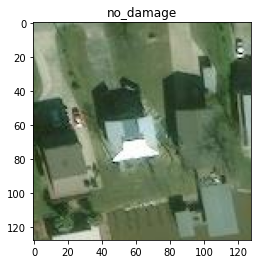

In [ ]:
plt.imshow(X_batch[4] / 255)
plt.title(trainDS.class_names[y_batch[4]]);

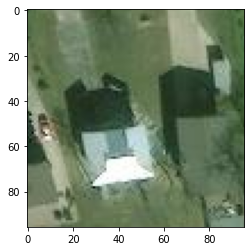

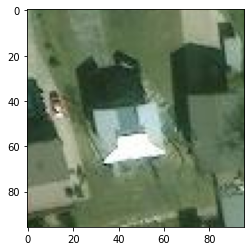

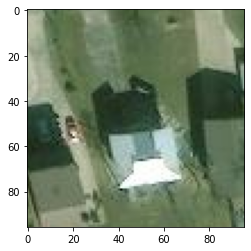

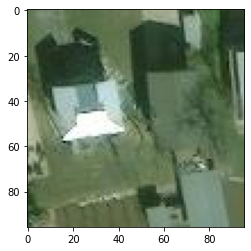

In [ ]:
crop = layers.RandomCrop(int(0.75 * imgHeight), int(0.75 * imgWidth))
for _ in range(4):
  plt.imshow(crop(X_batch[4] / 255))
  plt.show()

In [ ]:
tf.random.set_seed(123)

num_filters = 15
num_conv_pools = 3
use_pooling = 0
num_neurons = 128
lr = 0.0003

model = keras.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)))

for i in range(num_conv_pools):
    model.add(layers.Conv2D(num_filters, 3, padding="same", activation="relu", name=f"conv{i}"))
    if use_pooling:
        model.add(layers.MaxPooling2D(name=f"pool{i}"))

model.add(layers.Flatten())
model.add(layers.Dense(num_neurons, activation="relu"))
model.add(layers.Dense(1))

opt = keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(opt, loss, metrics="accuracy")

In [ ]:
epochs = 100
es = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)

In [ ]:
hist = model.fit(trainDS, validation_data=valDS,
  epochs=epochs, callbacks=[es], verbose=1)

Epoch 1/100
403/403 [==============================] - 30s 42ms/step - loss: 0.4885 - accuracy: 0.7965 - val_loss: 0.2672 - val_accuracy: 0.8946
Epoch 2/100
403/403 [==============================] - 15s 37ms/step - loss: 0.2367 - accuracy: 0.9058 - val_loss: 0.1897 - val_accuracy: 0.9286
Epoch 3/100
403/403 [==============================] - 15s 37ms/step - loss: 0.1591 - accuracy: 0.9393 - val_loss: 0.1756 - val_accuracy: 0.9293
Epoch 4/100
403/403 [==============================] - 15s 37ms/step - loss: 0.1146 - accuracy: 0.9542 - val_loss: 0.1461 - val_accuracy: 0.9381
Epoch 5/100
403/403 [==============================] - 18s 43ms/step - loss: 0.0794 - accuracy: 0.9702 - val_loss: 0.1512 - val_accuracy: 0.9423
Epoch 6/100
403/403 [==============================] - 17s 41ms/step - loss: 0.0501 - accuracy: 0.9819 - val_loss: 0.1599 - val_accuracy: 0.9430
Epoch 7/100
403/403 [==============================] - 20s 50ms/step - loss: 0.0311 - accuracy: 0.9909 - val_loss: 0.2007 - val_ac

In [ ]:
model.evaluate(valDS)

135/135 [==============================] - 3s 20ms/step - loss: 0.1676 - accuracy: 0.9467


[0.1675582081079483, 0.946707010269165]

In [ ]:
def build_model(hp):
    tf.random.set_seed(123)

    num_filters = hp.Choice("num_filters", [1, 2, 4, 8, 16])
    num_conv_pools = hp.Int("num_conv_pools", 1, 4)
    use_pooling = hp.Choice("use_pooling", [False, True])
    num_neurons = hp.Choice("num_filters", [1, 2, 4, 8, 16, 32, 64, 128])
    
    model = keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)))
    
    for i in range(num_conv_pools):
        model.add(layers.Conv2D(num_filters, 3, padding="same", activation="relu", name=f"conv{i}"))
        if use_pooling:
            model.add(layers.MaxPooling2D(name=f"pool{i}"))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(num_neurons, activation="relu"))
    model.add(layers.Dense(1))
    
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    opt = keras.optimizers.RMSprop(learning_rate=lr)
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    model.compile(opt, loss, metrics="accuracy")

    return model

In [ ]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
  build_model,
  objective="val_accuracy",
  max_trials=4,
  seed=42,
  directory="keras-tuner",
  project_name="hurricane-cnn")

es = keras.callbacks.EarlyStopping(patience=4, monitor="val_accuracy", restore_best_weights=True)

tuner.search(trainDS, epochs=200, callbacks = [es],
             validation_data=valDS, class_weight={0: 1, 1: 10})

bestModel = tuner.get_best_models()[0]

Trial 4 Complete [00h 01m 13s]
val_accuracy: 0.33535024523735046

Best val_accuracy So Far: 0.9413544535636902
Total elapsed time: 00h 06m 20s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in keras-tuner/hurricane-cnn
Showing 10 best trials
Trial summary
Hyperparameters:
num_filters: 8
num_conv_pools: 2
use_pooling: 1
lr: 0.0007102715674987189
Score: 0.9413544535636902
Trial summary
Hyperparameters:
num_filters: 1
num_conv_pools: 1
use_pooling: 1
lr: 6.540730319855325e-05
Score: 0.6646497845649719
Trial summary
Hyperparameters:
num_filters: 1
num_conv_pools: 2
use_pooling: 1
lr: 1.5872740971656706e-05
Score: 0.6646497845649719
Trial summary
Hyperparameters:
num_filters: 16
num_conv_pools: 4
use_pooling: 1
lr: 0.01
Score: 0.33535024523735046


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'lr': 0.0007102715674987189,
 'num_conv_pools': 2,
 'num_filters': 8,
 'use_pooling': 1}

In [ ]:
def build_model():
    tf.random.set_seed(123)

    num_filters = 15 # 25
    num_conv_pools = 3 # 4
    use_pooling = 0
    num_neurons = 128 # 256
    lr = 0.0003 # 0.0001

    model = keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)))
    # model.add(layers.RandomRotation(1))
    model.add(layers.RandomCrop(int(0.75 * imgHeight), int(0.75 * imgWidth)))
    for i in range(num_conv_pools):
        model.add(layers.Conv2D(num_filters, 3, padding="same", activation="relu", name=f"conv{i}"))
        if use_pooling:
            model.add(layers.MaxPooling2D(name=f"pool{i}"))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(num_neurons, activation="relu"))
    model.add(layers.Dense(1))
    

    opt = keras.optimizers.Adam(learning_rate=lr)
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    model.compile(opt, loss, metrics="accuracy")

    return model

In [ ]:
epochs = 100
es = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)

In [ ]:
model = build_model()
hist = model.fit(trainDS, validation_data=valDS,
  epochs=epochs, callbacks=[es], verbose=1)

Epoch 1/100
403/403 [==============================] - 25s 29ms/step - loss: 0.5242 - accuracy: 0.7524 - val_loss: 0.3828 - val_accuracy: 0.8818
Epoch 2/100
403/403 [==============================] - 11s 26ms/step - loss: 0.2854 - accuracy: 0.8826 - val_loss: 0.2237 - val_accuracy: 0.9181
Epoch 3/100
403/403 [==============================] - 11s 26ms/step - loss: 0.2243 - accuracy: 0.9120 - val_loss: 0.2158 - val_accuracy: 0.9253
Epoch 4/100
403/403 [==============================] - 11s 27ms/step - loss: 0.1980 - accuracy: 0.9197 - val_loss: 0.1706 - val_accuracy: 0.9348
Epoch 5/100
403/403 [==============================] - 12s 29ms/step - loss: 0.1850 - accuracy: 0.9265 - val_loss: 0.1703 - val_accuracy: 0.9344
Epoch 6/100
403/403 [==============================] - 11s 27ms/step - loss: 0.1718 - accuracy: 0.9305 - val_loss: 0.1744 - val_accuracy: 0.9362
Epoch 7/100
403/403 [==============================] - 11s 26ms/step - loss: 0.1643 - accuracy: 0.9340 - val_loss: 0.1681 - val_ac

In [ ]:
model.evaluate(valDS)

135/135 [==============================] - 3s 24ms/step - loss: 0.0725 - accuracy: 0.9725


[0.07250971347093582, 0.9725390076637268]

In [ ]:
model.evaluate(testDS)

135/135 [==============================] - 2s 16ms/step - loss: 0.0811 - accuracy: 0.9740


[0.08113255351781845, 0.9739595651626587]